# Week 3: Convolutional Neural Networks with Keras

**Group:** CCTS<br>

**Members**:
   + Chiara Maccani (2027591)
   + Samuele Piccinelli (2027650)
   + Tommaso Stentella (2027586)
   + Cristina Venturini (2022461)

# Introduction

The goal of this notebook is to train and test a Convolutional Neural Network (CNN) on a given dataset and to test some of its characteristics.

We import useful libraries and dependecies:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import random
from math import log, sin, pi
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.losses import categorical_crossentropy
from keras import initializers, regularizers
from keras import optimizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

plt.rc('font', family='serif', size=8)
plt.rc('mathtext', fontset='cm')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=20)
plt.rc('figure', titlesize=15)

# Dataset

We consider a dataset made of $N=10000$ samples $x[n][l]$ divided in rows of length $L=60$: to build it, each number $x[n][l]$ is obtained by adding a random number drawn from a double exponential (centered on a `bias` with typical scale `DX`) to the previous one $x[n][l-1]$. The goal of the network is to distinguish $2$ different patterns of the form $$(3-2y[n])A\sin\left(\pi \frac{i}{Z}\right)$$ from the absence of patterns.<br>
Each sample is classified by labels $y[n]$ with the patterns having value $1$ or $2$ and the absence of pattern value $0$. In order to generate the desired sequence, the pattern is added to the $x[n][i]$ elements with $i$ varying over $[l_0+l]$, where $l_0$ is a random integer in the interval $[0,L-1-Z]$.

In [2]:
step = lambda DX, bias: round(((log(random.random())) * DX) * 2 * (random.randint(0,1)-0.5) + bias)

def pattern(y,z,a,i):
    return round((3-2*y)*a*sin(pi*i/z))

def data_generator(DX, bias, Z, A, N=10000, L=60):
    y = np.zeros((N))
    x = np.zeros((N,L))

    for n in range(N):
        if n>0:
            x[n][0] = x[n-1][-1]
        for j in range(1,L):
            x[n][j] = x[n][j-1]+step(DX,bias)
        
        y[n] = n%3
        if y[n]>0:
            j0 = random.randint(0,L-1-Z)
            for j in range(Z):
                x[n][j0+j] += pattern(y[n], Z,A,j)
    return x, y

# 1. Reducing the signal-to-noise ratio

We first consider the network built in class and try to reduce the signal-to-noise ratio, namely the amplitude of the external signal in the data $A$ with respect to the typical step size $DX$ of the jump process in order to check where the network starts to fail discriminating the categories.

We define a list of $6$ different amplitudes and iterate the training procedure on all of them.

In [3]:
random.seed(12345)
Z = 12
A = [500, 400, 300, 200, 100, 50]
n_ampli = 6

N, L = 10000, 60

DX, bias = 50, 5

x = np.zeros((N,L,n_ampli))
categ = np.zeros((N,n_ampli))

for i in range(n_ampli):
    x[:,:,i], categ[:,i] = data_generator(DX, bias, Z, A[i])

In [4]:
for n in range(N):
    for i in range(n_ampli):
        x[n,:,i] = (x[n,:,i]-x[n,:,i].mean())/x[n,:,i].std()

N_categ = 3
y = np.zeros((N,N_categ,n_ampli))

for n in range(N):
    for j in range(n_ampli):
        y[n,int(categ[n,j]),j] = 1.
    
perc_train = 0.8
N_train = int(N*perc_train)

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

In [5]:
x_train = x_train.reshape(x_train.shape[0], L, n_ampli, 1)
x_val = x_val.reshape(x_val.shape[0], L, n_ampli, 1)
input_shape = (L,1)

In [6]:
reg = regularizers.l1(0.01)
np.random.seed(12345)
ini = initializers.RandomNormal(mean=0,stddev=0.05)

model = Sequential()
model.add(Conv1D(filters=5, kernel_size=11, kernel_regularizer=reg, kernel_initializer=ini,
                 activation="relu", input_shape=input_shape))
model.add(AveragePooling1D(5))
model.add(Conv1D(filters=5, kernel_size=7,
                activation="relu"))
model.add(Flatten())
model.add(Dense(10,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(N_categ, activation="softmax"))

print(model.summary())

model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [7]:
batch_size = 250
epochs = 50

fit = [0 for i in range(n_ampli)]
predicted_label = []

for i in range(n_ampli):
    fit[i]=model.fit(x_train[:,:,i], y_train[:,:,i], batch_size=batch_size, epochs=epochs,
                         validation_data=(x_val[:,:,i],y_val[:,:,i]), verbose=0, shuffle=True)
    predicted_label.append(model.predict(x_val[:,:,i])) 

In [ ]:
'''
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(nrows = 3, ncols= 2, figsize=(22, 25), sharex=True)

ax = [ax1,ax2,ax3,ax4,ax5,ax6]
axd = [ax[n].twinx() for n in range(len(ax))]

for i in range(n_ampli):
    ax[i].plot(fit[i].history['accuracy'], 'r')
    ax[i].plot(fit[i].history['val_accuracy'], color='r', linestyle='dashed')
    axd[i].plot(fit[i].history['loss'], color='b')
    axd[i].plot(fit[i].history['val_loss'], color='b', linestyle='dashed')
    ax[i].set_ylabel('Accuracy', color='r', size=18)
    axd[i].set_ylabel('Loss', color='b', size=18)
    ax[i].set_xlabel('Epoch', size=18)
    ax[i].set_title(f'$A=${A[i]}', size=25)
    
fig.tight_layout()
plt.show()
'''
# In the plots above the dashed line represents the accuracy/loss on the validation dataset.

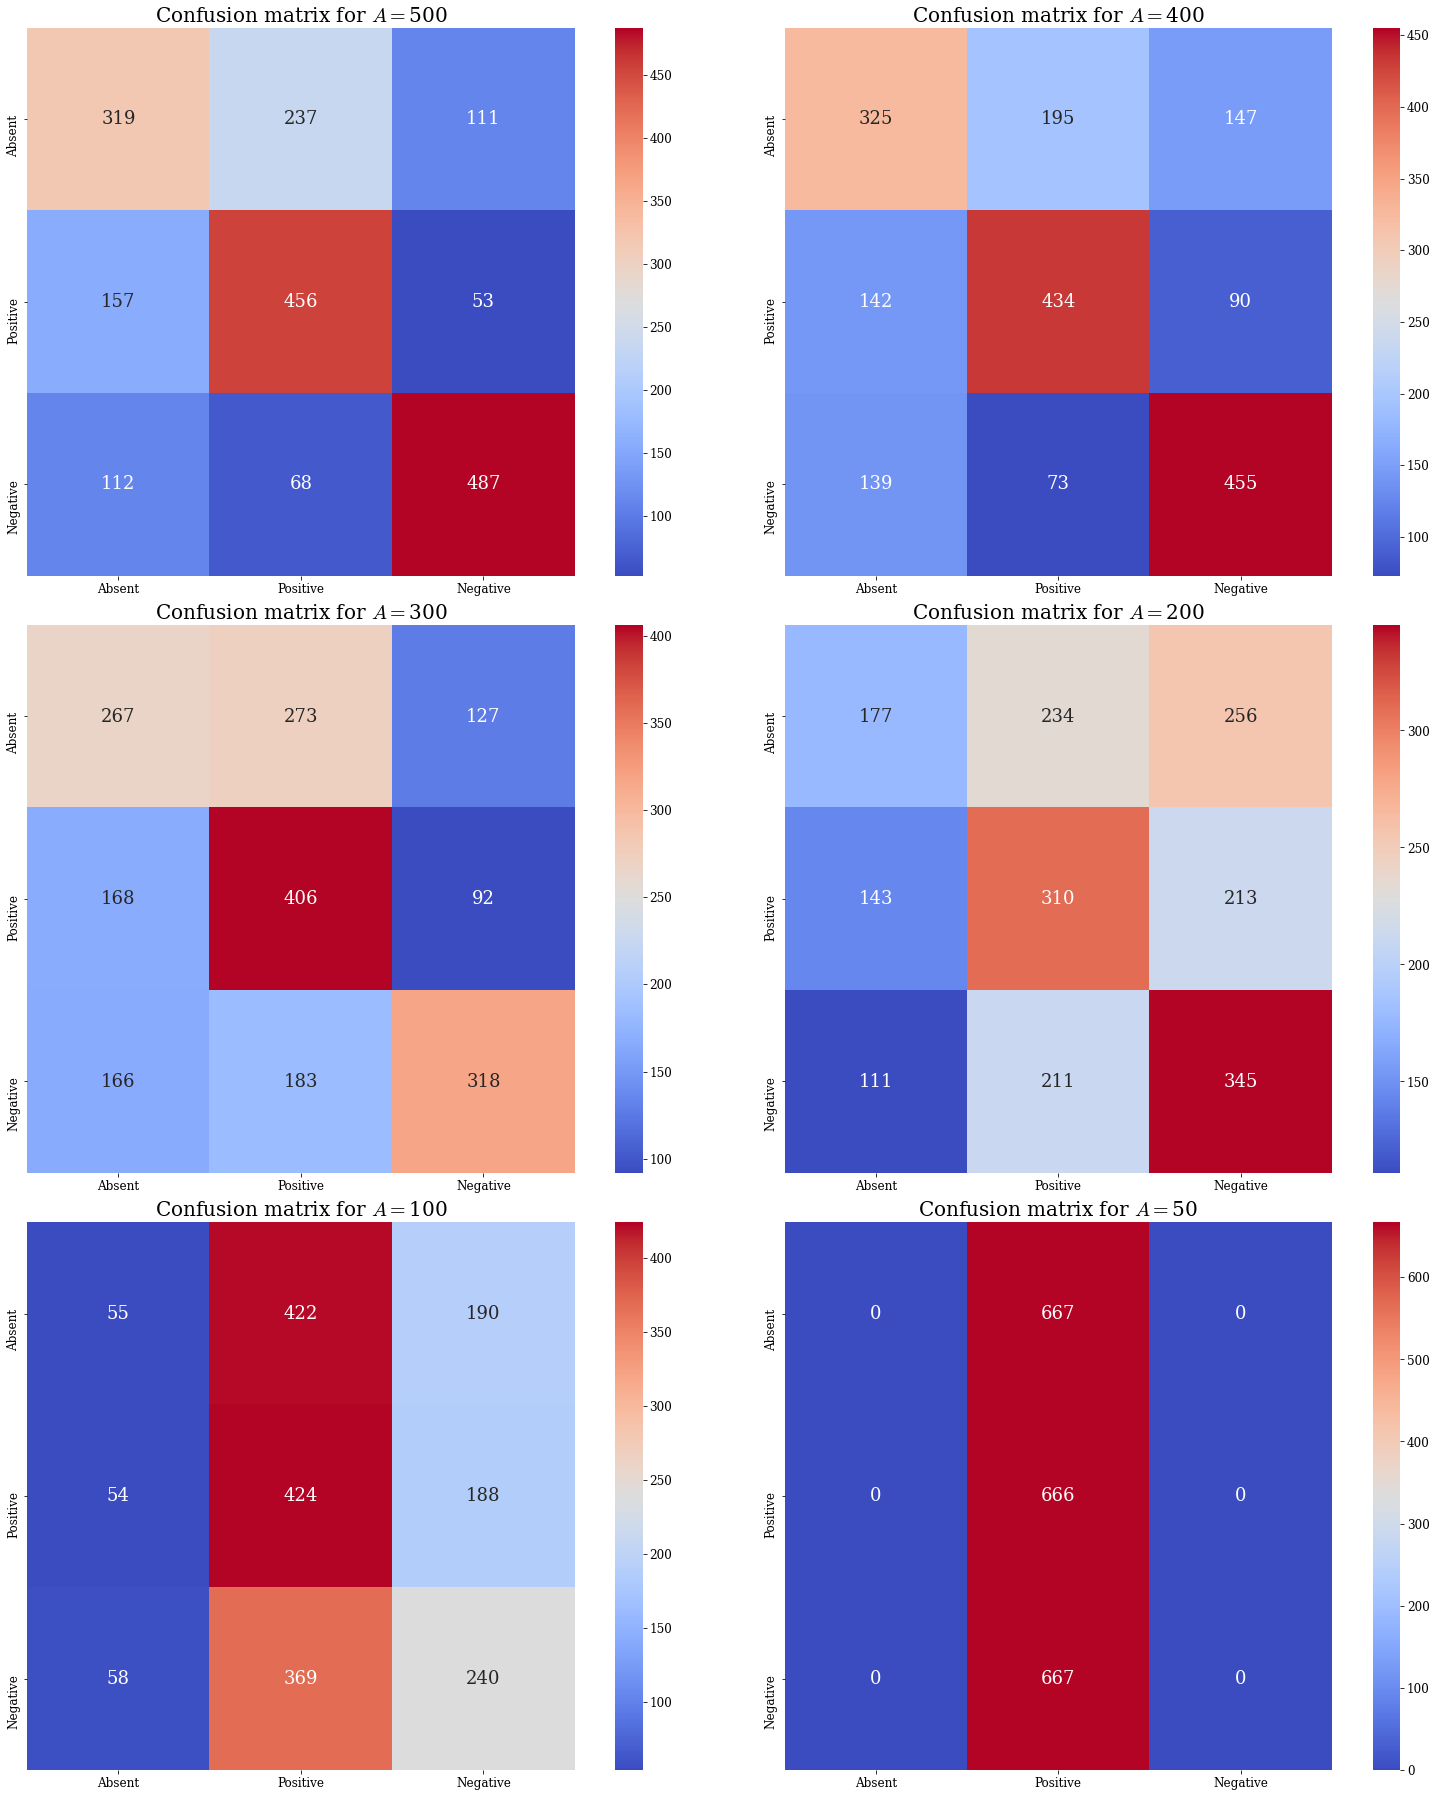

In [8]:
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(nrows = 3, ncols= 2, figsize=(22, 25))
ax = [ax1,ax2,ax3,ax4,ax5,ax6]

for i in range(n_ampli):
    Y_pred = predicted_label[i]
    c = confusion_matrix(y_val[:,:,i].argmax(axis=1), np.argmax(Y_pred, axis=1))
    df = pd.DataFrame(c, index = ["Absent", "Positive", "Negative"], columns = ["Absent", "Positive", "Negative"])
    sn.heatmap(df, annot=True, cmap="coolwarm", square=True, fmt='.0f', annot_kws={"fontsize":18}, ax=ax[i])
    ax[i].set_title(f'Confusion matrix for $A=${A[i]}', size=20)
fig.tight_layout()
plt.show()

The confusion matrices give a visual representation of the performance of the different models. The first $2$ ($500$, $400$) perform quite well, while when the ratio $A/DX$ decreases below $\sim6$ the network starts failing the classification task. At $A=200$ the confusion matrix is definitely "not diagonal".

# 2. Convolutional Neural Network

In this section we implement a version of a CNN where only a convolutional layer of depth $1$ (one set of weights and a single bias) is introduced instead of two; no constrain is posed for the number of dense layers, provided that the number of trainable parameters doesn't exceed $600$. The dataset used in this case has the same structure as in the previous point but this time both $Z$ and $A$ are unknowns.

We first load the file containing the labeled samples. In order to help the convergence of the training we chose to change the way we scale the input. We want the network to learn to recognize a "bump" in the signal. Specifically, while the signal stochastically oscillates, the bumps always have the same amplitude: to facilitate the task, it's important that all the bumps are similar to one another. This is obtained by using the same scale factor for all samples and not by recalculating it for each one of them: we normalize the features by subtracting the mean $\bar{x}_l$ of the $l$-th row to each sample $x[n][l]$ and by dividing it by the standard deviation $std = \sqrt{\sum_{i=1}^L (x[n][i] - \bar{x})^2}$ of the whole dataset.

The plot shows the first $3$ inputs of the dataset: the $y$-axis range is being rescaled as expected. The labels are then one-hot encoded.<br>
Below we define the number of samples in test and train sets, divided with $80-20\%$ split.

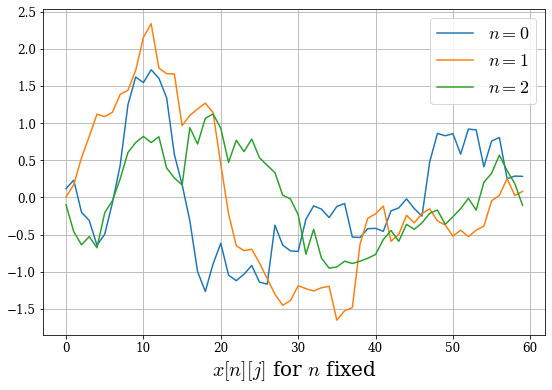

In [9]:
fnamex = 'DATA/x_ts_comp_N10000.csv'
fnamey = 'DATA/y_ts_comp_N10000.csv'

x = np.loadtxt(fnamex, delimiter=',', dtype=float)
N = len(x)

xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n]-xm[n]
x = x/x.reshape((N*L)).std()

fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(x[0], label=r'$n=0$')
plt.plot(x[1], label=r'$n=1$')
plt.plot(x[2], label=r'$n=2$')
plt.xlabel(r'$x[n][j]$ for $n$ fixed', size=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

categ = np.loadtxt(fnamey, delimiter=',', dtype=int)
N_categ = 3
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1.

In [10]:
perc_train = 0.8
N_train = int(N*perc_train)
N_val = N - N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

L = len(x[0])
print(f'\nTotal number of samples: {N}\nSamples train set: {N_train}\nSamples test set: {N_val}')


Total number of samples: 10000
Samples train set: 8000
Samples test set: 2000


In order to feed the data to the CNN we first need to reshape the training and test input data as follows.

In [11]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

## 2.1 Building the model

We build 2 different architectures in order to explore how the number, type and size of layers influences the number of total parameters. The specifics of each are summarized below. In their 2015 paper, He _et. al._ demonstrated that deep networks would converge much earlier if the input weights were initialized with numbers randomly chosen from a standard normal distribution with $\mu=0$ and $\sigma=\sqrt{2/N}$, where $N$ is the number of inputs (Kaiming initialization). This is implemented in this case since we make use of a non-linear activation function (ReLu).

Moreover we used batch normalization. The basic idea is to insert extra layers that normalize data after fully-connected and convolutional layers in the network. This optimizes the data flow dynamically, which allows the network to achieve good results with a wider range of initialization strategies.

To reduce the number of trainable layers and to exploit the spatial correlation we implemented also a global max pooling layer before the fully-connected block.

In [12]:
def create_CNN_1(val1, t, val2=0):
    np.random.seed(12345)
    ini = initializers.RandomNormal(mean=0,stddev=np.sqrt(2/1e4)) #previously 0.05
    if t == 'l1':
        reg = regularizers.l1(val1)
    if t == 'l2':
        reg = regularizers.l2(val1)
    if t == 'l1_l2':
        reg = regularizers.l1_l2(val1, val2)

    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=15, kernel_regularizer=reg,
                     kernel_initializer=ini, activation='relu', input_shape=input_shape, use_bias=False))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(27,activation='relu'))
    model.add(Dense(9,activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(N_categ,activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    return model

def create_CNN_2(val1, t, val2=0):
    np.random.seed(12345)
    ini = initializers.RandomNormal(mean=0,stddev=np.sqrt(2/1e4)) #previously 0.05
    if t == 'l1':
        reg = regularizers.l1(val1)
    if t == 'l2':
        reg = regularizers.l2(val1)
    if t == 'l1_l2':
        reg = regularizers.l1_l2(val1, val2)

    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=15, kernel_regularizer=reg,
                     kernel_initializer=ini, activation='relu', input_shape=input_shape, use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10,activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(N_categ,activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    return model

In [13]:
model_1 = create_CNN_1(0.0001, 'l1')
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 46, 6)             90        
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 6)             24        
_________________________________________________________________
global_max_pooling1d (Global (None, 6)                 0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                189       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 252       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                

In [14]:
batch_size = 250
epochs = 50

fit1=model_1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0, shuffle=True)

best_val_acc1 = np.max(fit1.history['val_accuracy'])
print("Best reached accuracy: ", best_val_acc1)

Best reached accuracy:  0.8464999794960022


In [15]:
model_2 = create_CNN_2(0.001, 'l2')
print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 46, 5)             75        
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 5)             20        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 5)             0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 5)                 0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                60        
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)               

In [16]:
batch_size = 250
epochs = 50

fit2=model_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(x_val,y_val), verbose=0, shuffle=True)

best_val_acc2 = np.max(fit2.history['val_accuracy'])
print("Best reached accuracy: ", best_val_acc2)

Best reached accuracy:  0.8385000228881836


## 2.2 Results

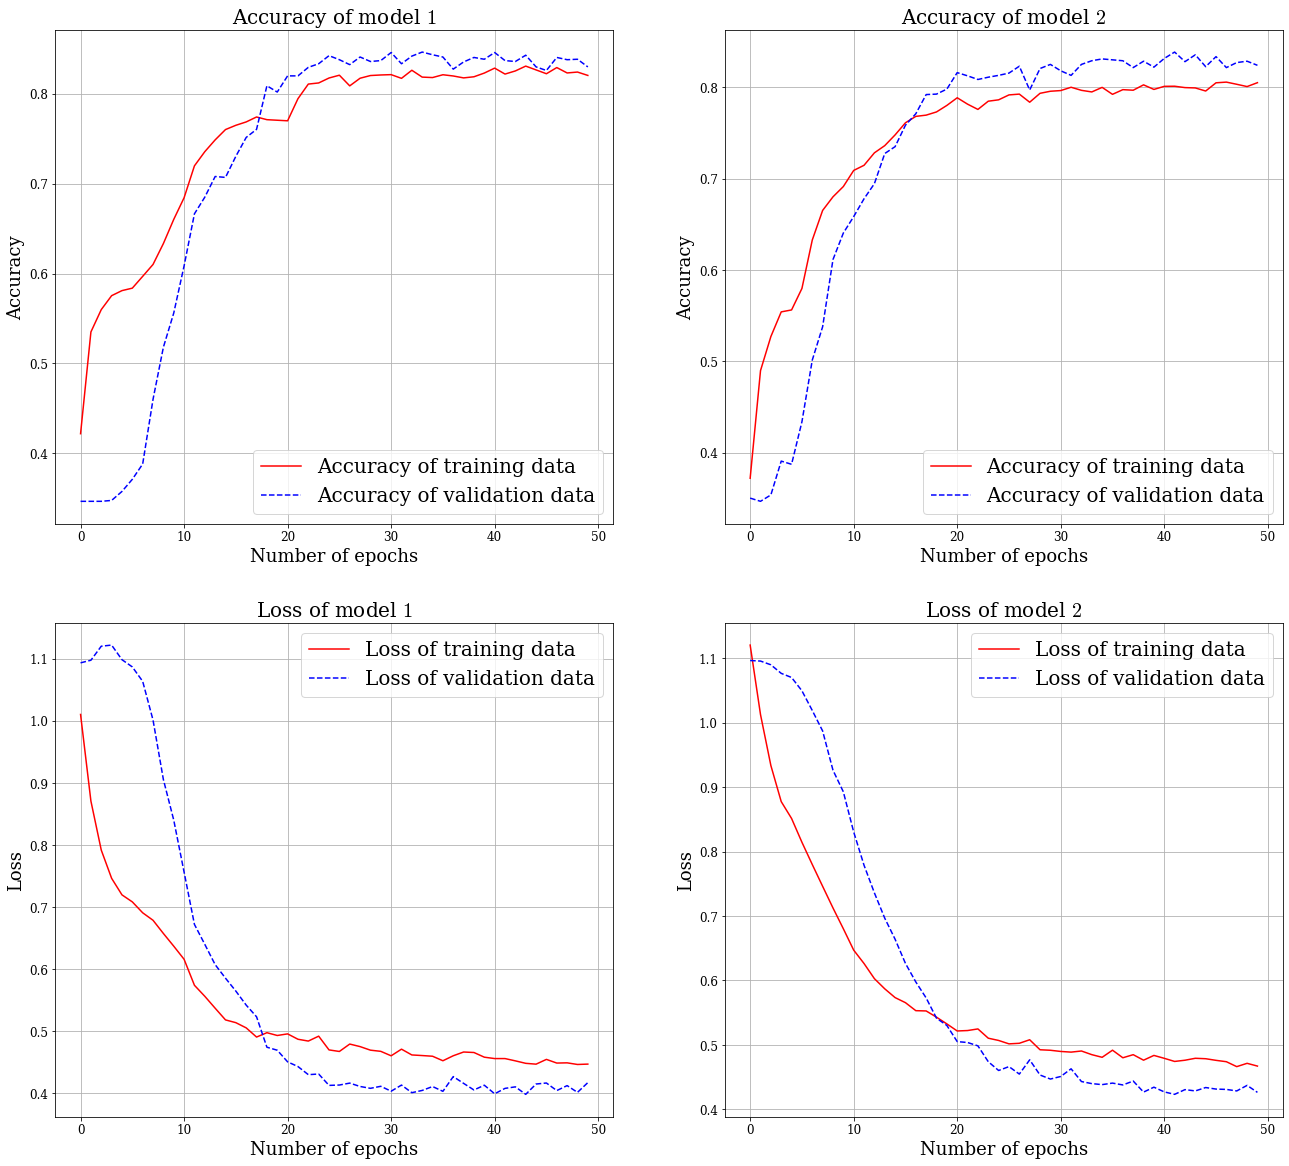

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(22, 20))
    
ax1.plot(fit1.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit1.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.set_title('Accuracy of model $1$')
ax1.grid(True)
ax1.legend(prop={'size': 20})

ax2.plot(fit2.history['accuracy'], 'r', label='Accuracy of training data')
ax2.plot(fit2.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Accuracy", size=18)
ax2.set_title('Accuracy of model $2$')
ax2.grid(True)
ax2.legend(prop={'size': 20})

ax3.plot(fit1.history['loss'], 'r', label='Loss of training data')
ax3.plot(fit1.history['val_loss'], 'b--', label='Loss of validation data')
ax3.set_xlabel("Number of epochs", size=18)
ax3.set_ylabel("Loss", size=18)
ax3.set_title('Loss of model $1$')
ax3.grid(True)
ax3.legend(prop={'size': 20})

ax4.plot(fit2.history['loss'], 'r', label='Loss of training data')
ax4.plot(fit2.history['val_loss'], 'b--', label='Loss of validation data')
ax4.set_xlabel("Number of epochs", size=18)
ax4.set_ylabel("Loss", size=18)
ax4.set_title('Loss of model $2$')
ax4.grid(True)
ax4.legend(prop={'size': 20})
plt.show()

From the graphs, one can see that for both cases the validation loss is lower than the training one, and that the validation accuracy is higher than the training one. <br>
There could be two possible explanations to this behaviour. <br>
It might be that our validation set consists of "easier" examples than the training set. However, it would have to be a large discrepancy to cause a difference between train/val results. <br> 
The other explanation concerns the use of dropout: due to disabling neurons, some of the information about each sample is lost, and the subsequent layers attempt to construct predictions based on incomplete representations. The training loss is higher because you make it artificially harder for the network to give the right answers. However, during validation all of the units are available, so the network has its full computational power - and thus it might perform better than in training.

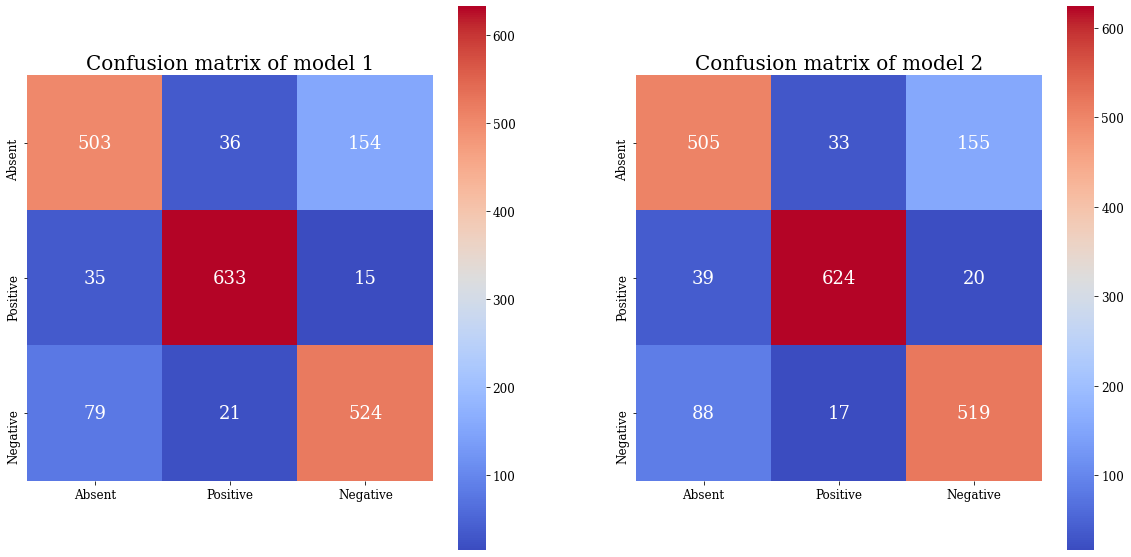

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(20, 10))

Y_pred_1 = model_1.predict(x_val)
Y_pred_2 = model_2.predict(x_val)
c1 = confusion_matrix(y_val.argmax(axis=1), np.argmax(Y_pred_1, axis=1))
c2 = confusion_matrix(y_val.argmax(axis=1), np.argmax(Y_pred_2, axis=1))
df1 = pd.DataFrame(c1, index = ["Absent", "Positive", "Negative"], columns = ["Absent", "Positive", "Negative"])
df2 = pd.DataFrame(c2, index = ["Absent", "Positive", "Negative"], columns = ["Absent", "Positive", "Negative"])
sn.heatmap(df1, annot=True, cmap="coolwarm", square=True, fmt='.0f', annot_kws={"fontsize":18}, ax=ax1)
sn.heatmap(df2, annot=True, cmap="coolwarm", square=True, fmt='.0f', annot_kws={"fontsize":18}, ax=ax2)
ax1.set_title(f'Confusion matrix of model 1', size=20)
ax2.set_title(f'Confusion matrix of model 2', size=20)
plt.show()

The $2$ different models behave very similarly and show no noticeable difference in terms of accuracy: for the further analysis the second is choosen since it has a smaller number of parameters and allows faster training performances.

From the confusion matrices one can see that the network confuses more frequently negative bump with absent bump. This may be because of the bias: the trend in the patterns is on average towards positive greater values, so a negative bump, on average, makes it more similar to a "flat" pattern.

The number of parameters is scaling more quickly by adding Dense layers than Conv1D layers, as expected: the dense layers are fully connected - in contrast to convolutional layers which make use of local connection and weight sharing - and thus inevitably increase the number of trainable parameters.

# 3. L1 & L2 Regularisation

In order to optimize the regularization of the chosen network it's possible to perform a grid search $3$ times, fixing the type (L1-Lasso, L2-Ridge and the mixed version L1_L2) and varying the amount of regularization, represented by the parameter  $\lambda$, in a range that goes from  $10^{−5}$  to  $1$.

In [19]:
val1 = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
val2 = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

t1= ['l1']
params1 = {'val1' : val1, 't' : t1}

model_gridsearch = KerasClassifier(build_fn=create_CNN_2, epochs=1, verbose=1)

grid1 = GridSearchCV(estimator=model_gridsearch, param_grid=params1, n_jobs=-1, cv=5)
grid_result1 = grid1.fit(np.concatenate((x_train, x_val)),np.concatenate((y_train, y_val)))

t2 = ['l2']
params2 = {'val1' : val1, 't' : t2}

grid2 = GridSearchCV(estimator=model_gridsearch, param_grid=params2, n_jobs=-1, cv=5)
grid_result2 = grid2.fit(np.concatenate((x_train, x_val)),np.concatenate((y_train, y_val)))

# l1_l2
t3 = ['l1_l2']
params3 = {'val1' : val1, 'val2' : val2, 't' : t3}

grid3 = GridSearchCV(estimator=model_gridsearch, param_grid=params3, n_jobs=-1, cv=5)
grid_result3 = grid3.fit(np.concatenate((x_train, x_val)),np.concatenate((y_train, y_val)))

print("L1 \tBest: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
print("L2 \tBest: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print("L1L2 \tBest: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))

313/313 [==============================] - 2s 5ms/step - loss: 1.0736 - accuracy: 0.3930
L1 	Best: 0.478700 using {'t': 'l1', 'val1': 0.0001}
L2 	Best: 0.468400 using {'t': 'l2', 'val1': 0.1}
L1L2 	Best: 0.544900 using {'t': 'l1_l2', 'val1': 1e-05, 'val2': 0.001}


It can be observed that the values of $\lambda$ that represent the best models are, in all cases, intermediate values of the chosen range.

The $3$ best models are then fitted with the training samples. In order to do a comparison, the value of the $15$ weights that consitute the $6$ filters of the convolutional layer are plotted.

In [20]:
best_l1=create_CNN_2(val1=grid_result1.best_params_['val1'], t=grid_result1.best_params_['t'])
best_l2=create_CNN_2(val1=grid_result2.best_params_['val1'], t=grid_result2.best_params_['t'])
best_l1l2=create_CNN_2(val1=grid_result3.best_params_['val1'], t=grid_result3.best_params_['t'], val2=grid_result3.best_params_['val2'])


fit = best_l1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0, shuffle=True)
best_val_acc = np.max(fit.history['val_accuracy'])
print(best_val_acc)

fit = best_l2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0, shuffle=True)
best_val_acc = np.max(fit.history['val_accuracy'])
print(best_val_acc)

fit = best_l1l2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0, shuffle=True)
best_val_acc = np.max(fit.history['val_accuracy'])
print(best_val_acc)

0.840499997138977
0.8395000100135803
0.8345000147819519


The best score is achieved by using L1 regularization with $\lambda=10^{-4}$.

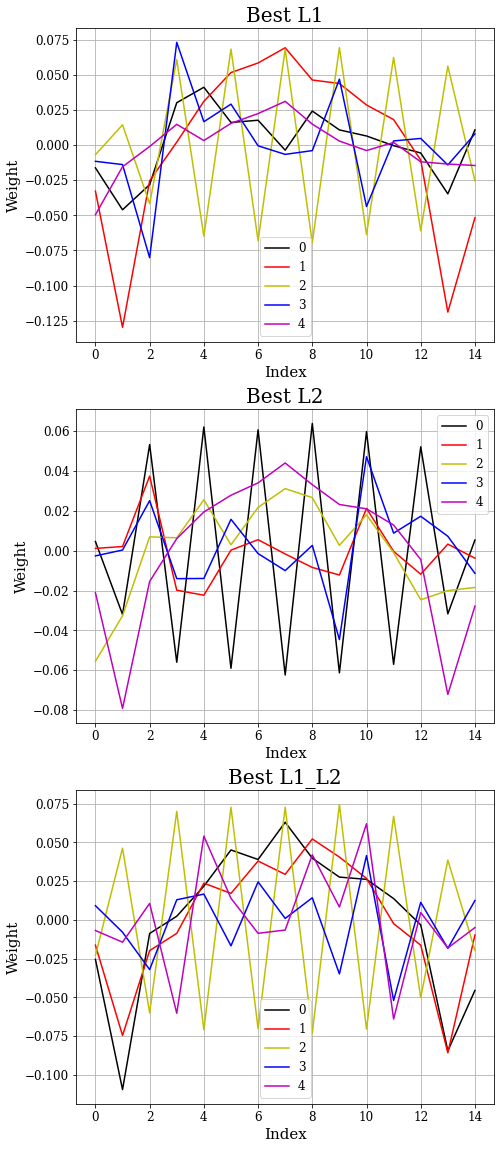

In [21]:
def plot_w(w, ax, title=None):
    #plot weights of convolutional layer
    c=['k','r','y','b', 'm','g']
    for i in range(len(w)):
        ax.plot(w[i][0], c[i], label=str(i) )
    ax.set_ylabel('Weight', size=15)
    ax.set_xlabel('Index', size=15)
    ax.set_title(title)
    ax.legend(prop={'size': 12})
    ax.grid(True)
    return ax

l1_w = (best_l1.layers[0].get_weights()[0]).T
l2_w = (best_l2.layers[0].get_weights()[0]).T
l1l2_w = (best_l1l2.layers[0].get_weights()[0]).T

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,16))
plot_w(l1_w, ax1, "Best L1")
plot_w(l2_w, ax2, "Best L2")
plot_w(l1l2_w, ax3, "Best L1_L2")
fig.tight_layout()
plt.show()

The found accuracies of the three models confirm the fact that the network performs good on our data. <br>
From the plots we can observe that the weights learned in different ways when using different regularizations. However the  chosen amount of regularization found by the grid search allows them to learn properly from data and to not remain flat near  zero.

We researched the benefits of a bias regularization: we haven't found much theoretical support on the matter but in general, what can be seen is that biases regularization is not as significant as weights regularization, at least in most cases.

As by Deep Learning (Goodfellow, Bengio, Courville, MIT Press, 2016) _"for neural networks, we typically choose to use a parameter norm penalty $\Omega$ that penalizes only the weights of the affine transformation at each layer and leaves the biases unregularized. The biases typically require less data than the weights to fit accurately. Each weight specifies how two variables interact. Fitting the weight well requires observing both variables in a variety of conditions. Each bias controls only a single variable. This means that we do not induce too much variance by leaving the biases unregularized. Also, regularizing the bias parameters can introduce a signiﬁcant amount of underfitting."_

Also, theoretically, if you regularized your biases you would be removing some flexibility from how your network functions. Allowing biases to grow large in magnitude may allow neurons to saturate faster without responding to outlier values that amount to noise in the training data. So, it makes intuitive sense that regularizing biases may worsen performance.

Given this considerations, we concluded it would be best not to regularize the biases, but to test it out, we actually tried to introduce some regularization for biases and also for the output of the relu units. The regularization was operated at the dense layers. <br>
We show our results in the image below, while we omit the code for brevity: as expected, performance did not improve, it actually slightly decreased.

<img src="mao.png" alt="Drawing" style="width: 1000px;"/>

# 4. Confusion matrix for Ex02

In this section we build a CNN model to adapt it to the classification of sequences of nucleic acid encoded in the DNA in exercise $2$. The results are then compared with the DNN model.

In [22]:
fname = 'DATA/sequences16.csv'
sx, sy = np.loadtxt(fname,delimiter=',',usecols=(0,1),unpack=True,dtype=str)

Nt = len(sy)
Ls = len(sx[0])

aug_x = np.array([[sx[i][-x:] + sx[i][:-x] for x in range(Ls)] for i in range(Nt)]).flatten()
aug_y = np.array([[sy[i] for _ in range(Ls)] for i in range(Nt)]).flatten()

N = len(aug_y)
Ls = len(aug_x[0])

perc_train = 0.8
N_train = int(N*perc_train)
N_val = N - N_train
print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_val}')

Q = ['A', 'C', 'G', 'T']
Nc = 4
onehc = {Q[i]:i for i in range(Nc)}

y = aug_y.astype(int)

L = Ls*Nc #number of characters in the string time the one hot encoding length

x = np.zeros((N,L))
for n in range(N):
    for i in range(Ls):
        x[n][i*4+onehc[aug_x[n][i]]] = 1

aux = np.zeros((len(aug_y), Ls*4+1))
aux[:,:Ls*4] = x
aux[:,Ls*4] = y
np.random.shuffle(aux)
x = aux[:,:Ls*4]
y = aux[:,Ls*4]

(x_train, y_train) = (x[:N_train], y[:N_train])
(x_val, y_val) = (x[N_train:], y[N_train:])


data: 48000
train: 38400
test: 9600


In [23]:
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val = x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L,1)

In [24]:
np.random.seed(12345)
reg = regularizers.l2(0.001)

model = Sequential()
model.add(Conv1D(filters=10, kernel_size=12, kernel_regularizer=reg, activation='sigmoid', input_shape=input_shape, use_bias=False))
model.add(MaxPooling1D(pool_size=(4)))
model.add(BatchNormalization())
model.add(Conv1D(filters=10, kernel_size=8, kernel_regularizer=reg, activation='sigmoid', use_bias=False))
model.add(BatchNormalization())

model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(16,activation='sigmoid'))
model.add(Dropout(0.15))

model.add(Dense(1,activation='sigmoid'))

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 53, 10)            120       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 13, 10)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 10)            40        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 6, 10)             800       
_________________________________________________________________
batch_normalization_9 (Batch (None, 6, 10)             40        
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 10)                0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 10)               

In [25]:
batch_size = 250
epochs = 50

fit=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0, shuffle=True)

best_val_acc = np.max(fit.history['val_accuracy'])
print(best_val_acc)

0.8968750238418579


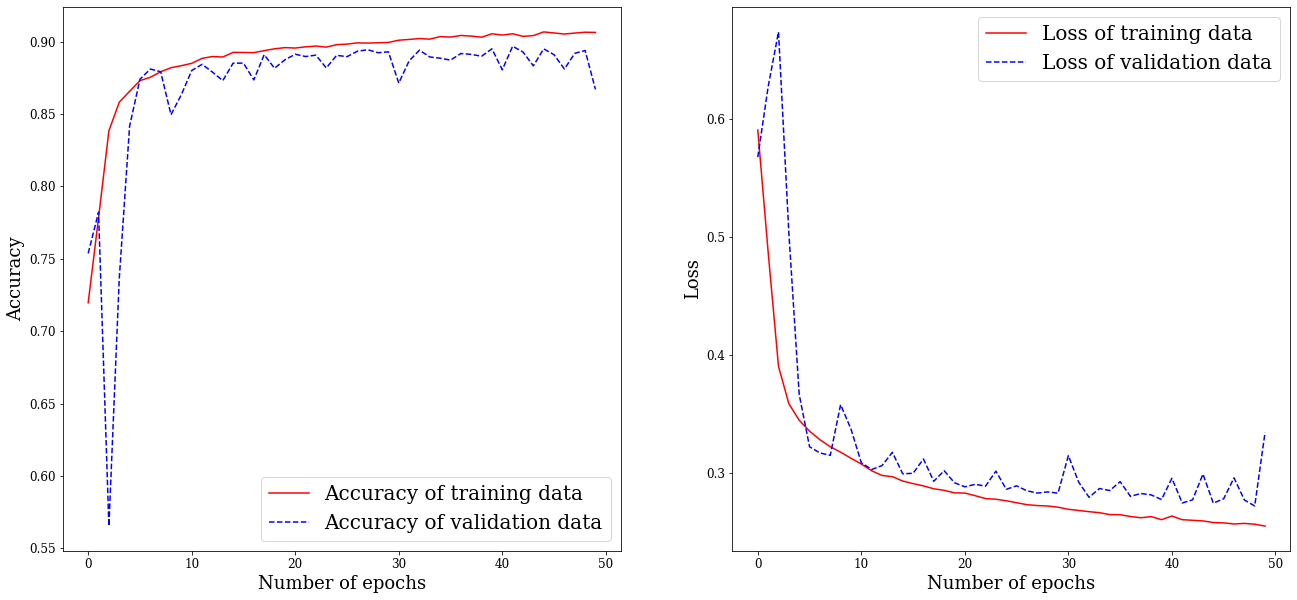

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

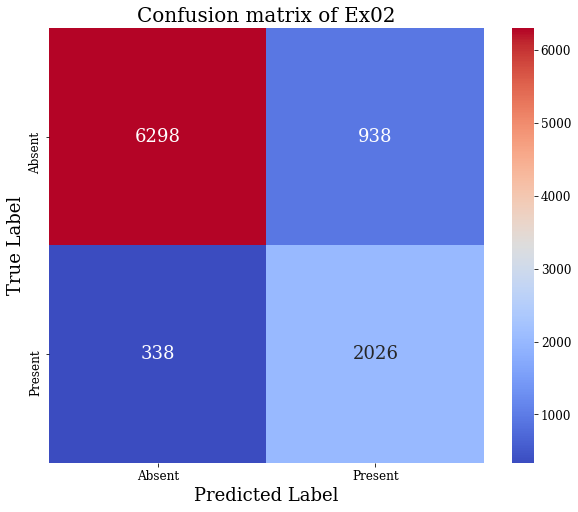

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols= 1, figsize=(10, 8))

Y_pred = model.predict(x_val)
l = []
for xi in Y_pred:
    if xi>0.5: l.append(1)
    else: l.append(0)

c = confusion_matrix(y_val, l)
df = pd.DataFrame(c, index = ["Absent", "Present"], columns = ["Absent", "Present"])
sn.heatmap(df, annot=True, cmap="coolwarm", square=True, fmt='.0f', annot_kws={"fontsize":18}, ax=ax)
ax.set_ylabel("True Label", size=18)
ax.set_xlabel("Predicted Label", size=18)
ax.set_title(f'Confusion matrix of Ex02', size=20)
plt.show()

The network performs well overall, although it is prone to false-positive: this can be due to the fact that by augmenting the data we inevitably introduced some wrong labels.

It can be seen that the network performs as well as the fully connected one previously used. In fact we reach a best validation accuracy of $\sim0.9$ for both cases, but in this case we have around $1000$ parameters less (the previous structure was composed by $64$ input nodes, $32$ and $16$ internal).